# __Puffins__

## NB 02 - Comparing regression methods and implementations

In NB01, we saw how we can use __puffins__ to flexibly model highly complex and non-sinusoidal periodic signals in time series data using a regression model with a "Fourier" feature embedding and weighting. 

In this notebook, we're going to look at how the model outputs change depending on what regression method we use. We're going to do this on two test cases - specifically, i) with the full U Gru data set of 15000 data points, and ii) on a random subset of 20% of the data. 

At the end, we'll also compare different numerical implementations for solving the equations.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from pythia.timeseries.lombscargle import LS_periodogram
from puffins.utils import construct_design_matrix
from puffins.basis_functions import basis_constant, basis_linear, basis_polynomial
from puffins.solver import solve
from puffins.weight_functions import matern32
from puffins.timeseries import TimeSeries,LinearModel


np.random.seed(8675309) # MAGIC to enforce reproducibility
RCOND = 1e-14 # MAGIC input to `np.linalg.lstsq()`
plotnum=1

In [2]:
# Load up the data
time, flux = np.loadtxt('../data/ugru.dat').T
N = len(time)
period = 1.88045
K = 300

Let's take a look at the raw data

In [3]:
data_full = TimeSeries(time, flux)
print(data_full)

TimeSeries with properties:
Time base of observations: 24.3899784208229
Number of data points: 15000
Median time step: 0.001388874274198315
Number of models computed: 0


In [4]:
## Select a random subset of 20% of the data
idx = np.random.randint(0, N-1, int(N*0.2))
time_subset = time[idx]
flux_subset = flux[idx]
data_subset = TimeSeries(time_subset, flux_subset)
print(data_subset)

TimeSeries with properties:
Time base of observations: 24.385811880888014
Number of data points: 3000
Median time step: 0.004166709436049132
Number of models computed: 0


Okay, so, we now have two data sets - and we're going to make a "Weighted Least Squares", "Ridge" and "Feature Weighted" regression model for each.

Each model will have the same basis functions that lead the design matrix (an offset and linear trend) and use the Fourier feature embedding with the same number of harmonics (K=300). Furthermore, none of the models will consider the uncertainties on the observations.

To make things easier, we're going to instantiate and train all of the models and add them to their respective data

First, for the full dataset.

In [15]:
wls_full = LinearModel(data_full, basis_functions=[basis_constant, basis_linear,], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None,
                   method='wls', period=period, n_harmonics=K, W=None)

ridge_full = LinearModel(data_full, basis_functions=[basis_constant, ], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None, alpha=0.5,
                   method='ridge', period=period, n_harmonics=K, W=None)

fw_full = LinearModel(data_full, basis_functions=[basis_constant,], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_width=0.1,
                   method='fw', period=period, n_harmonics=K, W=None)


In [16]:
wls_full.set_X_train()
wls_full.train()

ridge_full.set_X_train()
ridge_full.train()

fw_full.set_X_train()
fw_full.train()

In [17]:
data_full.add_model(wls_full)
data_full.add_model(ridge_full)
data_full.add_model(fw_full)

Now for the random subset of data.

In [18]:
wls_subset = LinearModel(data_subset, basis_functions=[basis_constant, basis_linear,], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None,
                   method='wls', period=period, n_harmonics=K, W=None)

ridge_subset = LinearModel(data_subset, basis_functions=[basis_constant, ], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None, alpha=0.5,
                   method='ridge', period=period, n_harmonics=K, W=None)

fw_subset = LinearModel(data_subset, basis_functions=[basis_constant, ], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_width=0.1,
                   method='fw', period=period, n_harmonics=K, W=None)


In [19]:
wls_subset.set_X_train()
wls_subset.train()

ridge_subset.set_X_train()
ridge_subset.train()

fw_subset.set_X_train()
fw_subset.train()

In [20]:
data_subset.add_model(wls_subset)
data_subset.add_model(ridge_subset)
data_subset.add_model(fw_subset)

Now that we've computed all the models for the different datasets, we're going to start comparing them.
First, we'll take a look at the model fits by eye. 
Then, we'll consider the scatter in the residuals, and finally we'll compare the values of the regression coefficients!

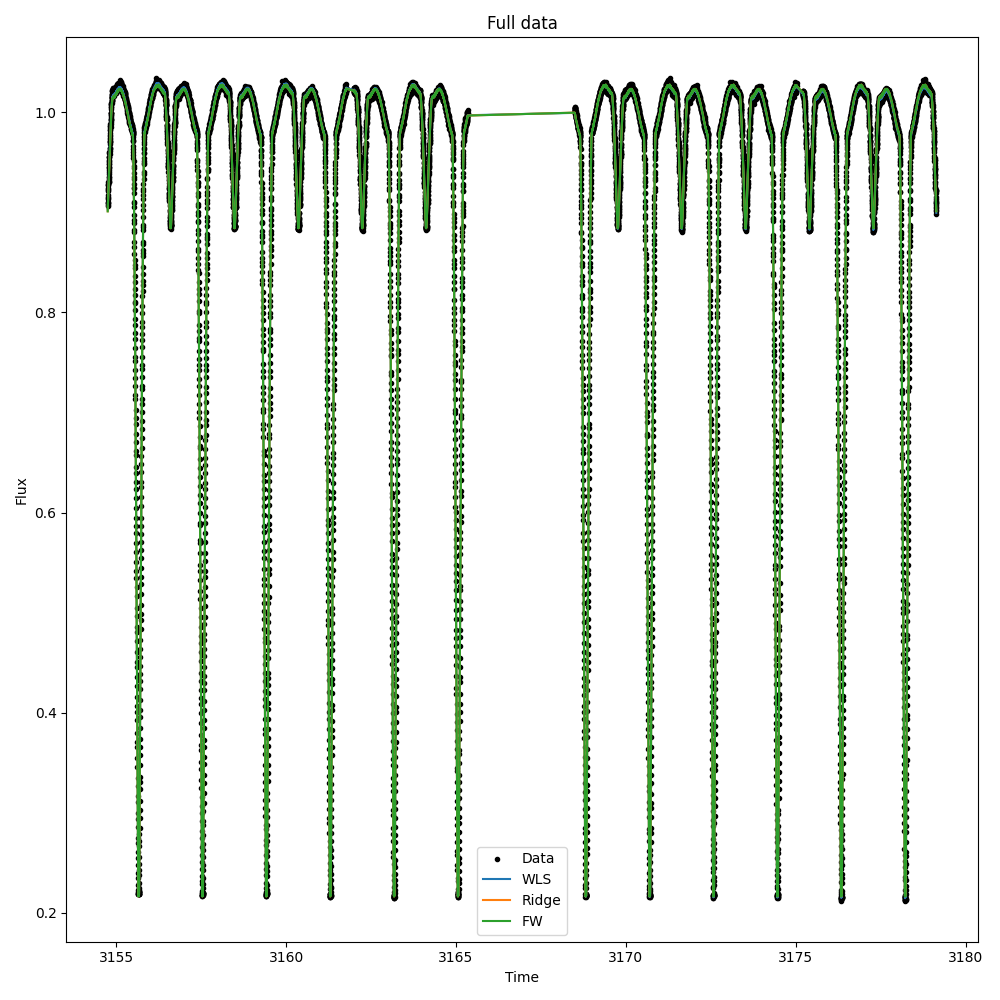

In [21]:
plotnum += 1
fig_full, ax_full = plt.subplots(1, 1, figsize=(10, 10), num=plotnum)
ax_full.plot(data_full.x, data_full.y, 'k.', label='Data')
ax_full.plot(data_full.x, data_full.models['wls'].predict(data_full.x)[1], label='WLS')
ax_full.plot(data_full.x, data_full.models['ridge'].predict(data_full.x)[1], label='Ridge')
ax_full.plot(data_full.x, data_full.models['fw'].predict(data_full.x)[1], label='FW')
ax_full.legend()
ax_full.set_xlabel('Time')
ax_full.set_ylabel('Flux')
ax_full.set_title('Full data')
fig_full.tight_layout()
plt.show()

Okay, by eye, they all look pretty good. But there will be some differences. Let's take a closer look at the distribution of residuals from the different methods. 

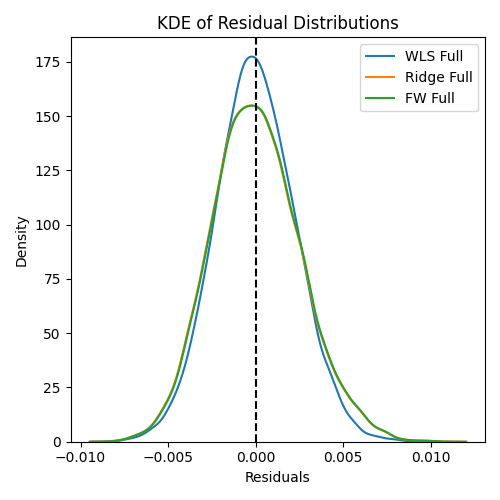

In [25]:
import seaborn as sns

# Plot KDE of residual distributions
plotnum += 1
fig_residuals, ax_residuals = plt.subplots(1, 1, figsize=(5, 5), num=plotnum)

sns.kdeplot(data_full.residuals['wls'], ax=ax_residuals, label='WLS Full')
sns.kdeplot(data_full.residuals['ridge'], ax=ax_residuals, label='Ridge Full')
sns.kdeplot(data_full.residuals['fw'], ax=ax_residuals, label='FW Full')

# sns.kdeplot(residuals_wls_subset, ax=ax_residuals, label='WLS Subset')
# sns.kdeplot(residuals_ridge_subset, ax=ax_residuals, label='Ridge Subset')
# sns.kdeplot(residuals_fw_subset, ax=ax_residuals, label='FW Subset')
ax_residuals.axvline(0, color='k', linestyle='--')
ax_residuals.legend()
ax_residuals.set_xlabel('Residuals')
ax_residuals.set_ylabel('Density')
ax_residuals.set_title('KDE of Residual Distributions')
fig_residuals.tight_layout()
plt.show()

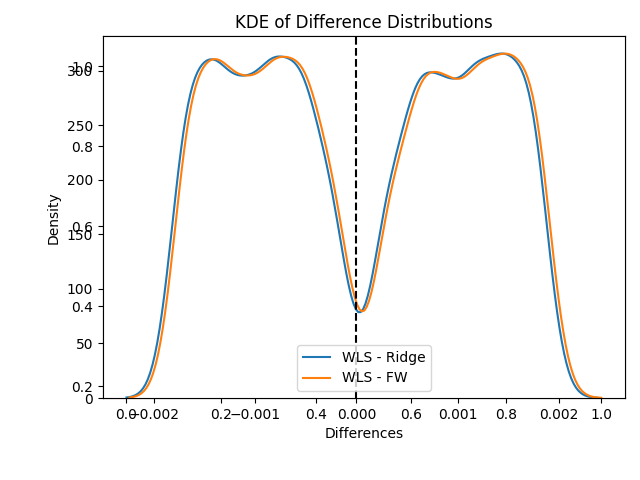

In [26]:
import seaborn as sns

# Plot KDE of residual distributions
plotnum += 1
fig_diffs, ax_diffs = plt.subplots(1, 1, figsize=(5, 5), num=plotnum)

sns.kdeplot(data_full.trained_models['wls']-data_full.trained_models['ridge'], ax=ax_diffs, label='WLS - Ridge')
sns.kdeplot(data_full.trained_models['wls']-data_full.trained_models['fw'], ax=ax_diffs, label='WLS - FW')

ax_diffs.axvline(0, color='k', linestyle='--')
ax_diffs.legend()
ax_diffs.set_xlabel('Differences')
ax_diffs.set_ylabel('Density')
ax_diffs.set_title('KDE of Difference Distributions')
fig_diffs.tight_layout()
plt.show()

Add commentary

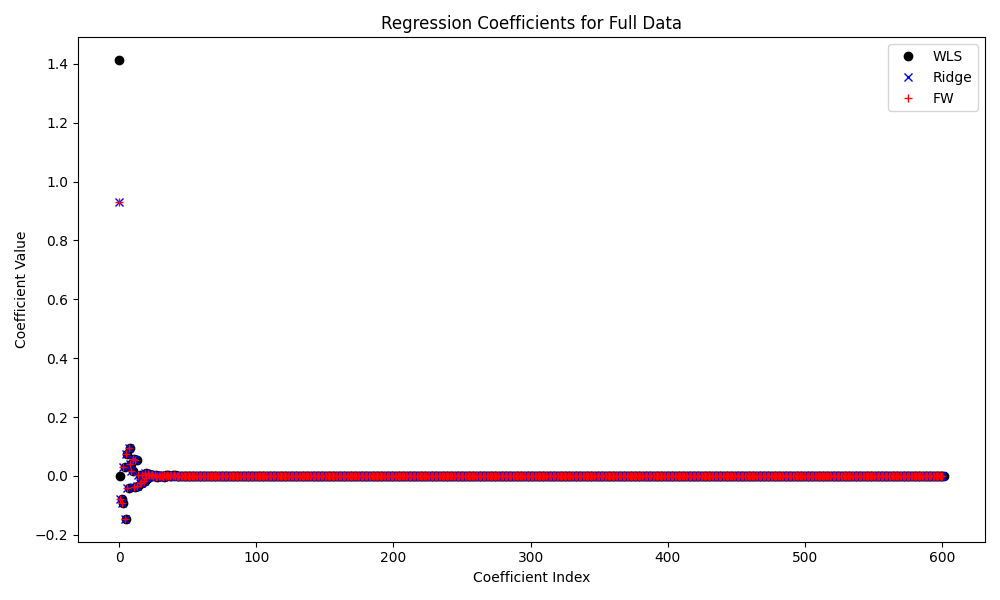

In [29]:
# Extract regression coefficients
coeffs_wls = wls_full.coefficients
coeffs_ridge = ridge_full.coefficients
coeffs_fw = fw_full.coefficients

# Plot the coefficients
plotnum += 1
fig_coeffs, ax_coeffs = plt.subplots(1, 1, figsize=(10, 6), num=plotnum)
ax_coeffs.plot(coeffs_wls, 'ko', label='WLS')
ax_coeffs.plot(coeffs_ridge, 'bx', label='Ridge')
ax_coeffs.plot(coeffs_fw, 'r+', label='FW')
ax_coeffs.legend()
ax_coeffs.set_xlabel('Coefficient Index')
ax_coeffs.set_ylabel('Coefficient Value')
ax_coeffs.set_title('Regression Coefficients for Full Data')
fig_coeffs.tight_layout()
plt.show()

In [ ]:
def ols_solve(X,y, weights=None):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    
    return np.linalg.solve( XTCinv @ X, XTCinv @ y)


def ols_lstsq(X, y, weights=None, rcond=1e-14):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    return np.linalg.lstsq(XTCinv @ X, XTCinv @ y, rcond=rcond)[0]


def ols_direct(X, y, weights=None):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    return np.linalg.inv(XTCinv @ X) @ XTCinv @ y

In [ ]:
betas_solve = ols_solve(X, flux)
betas_lstsq = ols_lstsq(X, flux)
betas_direct = ols_direct(X, flux)

syn_solve = X @ betas_solve
syn_lstsq = X @ betas_lstsq
syn_dir = X @ betas_direct

plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ax_.plot(time, syn_lstsq, 'k-')
ax_.plot(time, syn_lstsq, 'r-')
ax_.plot(time, syn_dir, 'b-')
ax_.plot(time, flux, 'o', color='grey', alpha=0.05)

plt.show()

In [ ]:
print(betas_solve[:4])
print(betas_lstsq[:4])
print(betas_direct[:4])

In [ ]:
diffs_ = syn_dir - syn_solve
## plot distribution of differencea

In [ ]:
diffs_2 = syn_lstsq - syn_solve
## plot distribution of differencea